In [1]:
import numpy as np
import numpy.ma as ma

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import random

import scipy.special
from scipy import ndimage
from scipy.constants import Boltzmann, epsilon_0, elementary_charge, hbar, electron_mass

In [2]:
#conversion factor
eV_to_J = 1.602176565*0.1**19

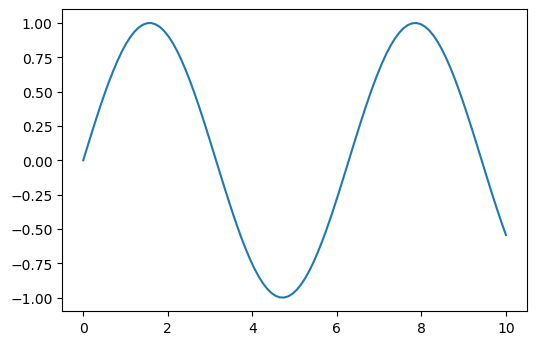

In [3]:
xx = np.linspace(0, 10, 100)
yy = np.sin(xx)

plt.figure(dpi=100)
plt.plot(xx, yy)

In [4]:
"""
Функции для постраения 3D графиков распредлениея
"""
def parse_array_for_plot(array, color_array, chosen_color_cnt):
    x_list = []
    y_list = []
    z_list = []
    color_list = []

    x_percolation_list = []
    y_percolation_list = []
    z_percolation_list = []

    nx, ny, nz = array.shape
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):

                if array[i, j, k] == 1:
                    x_list.append(i)
                    y_list.append(j)
                    z_list.append(k)
                    color_list.append(color_array[i,j,k])
                    if color_array[i,j,k] == chosen_color_cnt:
                        x_percolation_list.append(i)
                        y_percolation_list.append(j)
                        z_percolation_list.append(k)

    # Initialise data to lists. 
    data = {'x': x_list,
            'y': y_list,
            'z': z_list,
            'color': color_list}
    data_p = {'x': x_percolation_list,
              'y': y_percolation_list,
              'z': z_percolation_list}
    
    df = pd.DataFrame(data)
    df_p = pd.DataFrame(data_p)
    return df, df_p

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, angle=320):
    cube = normalize(cube)
    
    facecolors = cm.viridis(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)
    
    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.add_subplot(projection = '3d')
    ax.view_init(30, angle)
    # ax.set_xlim(right=IMG_DIM*2)
    # ax.set_ylim(top=IMG_DIM*2)
    # ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)
    plt.show()

In [6]:
class structure:
    """
    Determines all parameters of model structre and
    containes informatation about fields in it
    """

    def get_flatten_index(self, coord_3d):
        """
        Converrts 3D-array index into 1D-arrray index

        Parameters
        ----------
        coord_3d : list
            3D index of the point

        Returns
        -------
        coord_1d : np.array
            1D index of the point
        """

        coord_1d = coord_3d[0]*self.nz*self.ny + coord_3d[1]*self.nz + coord_3d[2]
        return coord_1d

    def get_3d_coord(self, flatten_index):
        """
        Converrts 1D-array index into 3D-arrray index

        Parameters
        ----------
        flatten_index : int
            1D index of the point

        Returns
        -------
        (x,y,z) : tuple
            3D index of the point
        """

        z     = flatten_index %  self.nz
        z_add = flatten_index // self.nz
        y = z_add %  self.ny
        x = z_add // self.ny
        return (x,y,z)


    def __init__(self):
        """
        Initialization of a starting parameters
        """
        
        # TODO: initiate throgh config file
        # volume sizes
        self.nx = 20
        self.ny = 20
        self.nz = 16
        # lattice constant
        self.lattice_constant = 0.5 # nm
        self.nm_to_cm = 0.1**9 * 10**2

        # Fields
        ## Temperature
        self.ambient_temperature = 300 # K
        self.temperature            = np.zeros((self.nx, self.ny, self.nz)) + self.ambient_temperature # K
        self.temperature_grad       = np.zeros((self.nx, self.ny, self.nz))
        self.power_dissipation_map  = np.zeros((self.nx, self.ny, self.nz))
        self.thermal_conductivity   = np.zeros((self.nx, self.ny, self.nz)) + 0.005 # W/cmK
        ## Electric
        self.electric_potential         = np.zeros((self.nx, self.ny, self.nz))
        self.electric_potential_grad    = np.zeros((self.nx, self.ny, self.nz))
        self.V_top = 1.0
        self.V_bottom = 0.0
        self.uniform_electric_potential = np.zeros((self.nx+2, self.ny+2, self.nz+2)) # Что это? (TODO: add description)
        self.oxide_permittivity = 25
        self.defect_permittivity = 1000
        self.insulator_permittivity_array = np.zeros((self.nx, self.ny, self.nz)) + self.oxide_permittivity
        # Current
        self.current = 0
        self.work_function_top = 4.5 # eV
        self.work_function_bottom = 4.5 # eV
        self.electron_affinity_top = 2.8 # eV
        self.electron_affinity_bottom = 2.8 # eV
        self.V_ox = self.V_top-self.V_bottom # V, полное падение напряжение, нужно для приближений
        self.hw0 = np.zeros((self.nx, self.ny, self.nz)) + 0.07 #eV, effective phonon energy
        self.S   = np.zeros((self.nx, self.ny, self.nz)) + 17   #  , Huang-Rhys factor
        self.trap_Bose_Einstien = np.zeros((self.nx, self.ny, self.nz))
        self.Fermi_level = np.zeros((self.nx, self.ny, self.nz)) # in the midle of the conduction zone
        self.trap_level = np.zeros((self.nx, self.ny, self.nz)) + 1.2 # eV
        self.E_gap = np.zeros((self.nx, self.ny, self.nz)) + 5.7 #eV
        self.effective_mass_coef = np.zeros((self.nx, self.ny, self.nz)) + 0.1
        self.electron_effective_mass = self.effective_mass_coef*electron_mass
        self.trap_capture_radius = np.zeros((self.nx, self.ny, self.nz)) + 0.1**7 #cm^2
        self.electrooptical_energy = 0.0 # np.zeros((self.nx, self.ny, self.nz))
        self.c_0 = np.zeros((self.nx, self.ny, self.nz)) #J*m**3
        self.trap_occupancy = np.zeros((self.nx, self.ny, self.nz))
        self.max_phonon_number = int(np.max([self.trap_level/self.hw0, (self.work_function_top-self.electron_affinity_top)/self.hw0, (self.work_function_bottom-self.electron_affinity_bottom)/self.hw0]))
        self.multiphonon_transition_probability = np.zeros((self.nx, self.ny, self.nz, self.max_phonon_number))

        # TODO: добавить поправки для энергий активации в зависимости от количества соседних дефектов
        # process thresholds
        self.E_d = 0.7  # keV
        self.E_g = 1.0  # keV
        self.E_r = 2.0  # keV
        self.molecular_dipole_moment = np.zeros((self.nx, self.ny, self.nz)) + 1.1*0.1**9 * 10**2 # C cm

        # # resistance, for fast current estimation
        # self.R_insulator = 1.0 * 10**10 # Ohm
        # self.R_defect = 1.0 * 10**3 # Ohm
        # self.resistance_map = np.zeros((self.nx-1, self.ny-1, self.nz+2))

        # array with vacancy distribution
        # self.vacancy_grid = np.zeros((self.nx, self.ny, self.nz))
        self.N_defect = 1.0 * 10**19 # cm-3, initial defect density
        prob = self.N_defect*((self.lattice_constant*self.nm_to_cm)**3)
        # self.vacancy_grid = np.random.choice(2, (self.nx, self.ny, self.nz), p=[1-prob, prob])
        self.vacancy_grid = np.zeros((self.nx, self.ny, self.nz))
        self.vacancy_grid[5:8, 5:8, :-3] = 1

        # decription of vacancy clusters
        self.last_cluster_cnt = 1 # Что это? (TODO: add description)
        self.vacancy_clusters = np.zeros((self.nx, self.ny, self.nz))
        self.percolation_cluster_cnt = 0

        # effective radius of the defect
        self.vacancy_radius = 0.5 # Какая размерность? (TODO: add description)

        # time of simulation
        self.simulation_time = 0.0
        self.overal_reaction_time = np.zeros((self.nx, self.ny, self.nz)) + self.simulation_time # to take into account exposure time
        self.max_time_step = 0.0 # Что это? (TODO: add description)


        # Что это? (TODO: add description)
        # Перенести в отдельный файл?
        self.transition_kernels = {
            #top
            0: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  1,  0),
                 (0, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #bottom
            1: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  0),
                 (0,  1,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #to
            2: (((0,  0,  0),
                 (0,  1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #from
            3: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1,  0),
                 (0,  0,  0))),

            #left
            4: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (1, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #right
            5: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  1),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #generation
            6: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #recombination
            7: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)))
        }
        self.transition_process_kernels = {
            #top
            0: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1,  0),
                 (0, -1,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #bottom
            1: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0, -1,  0),
                 (0,  1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #to
            2: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  0),
                 (0,  0,  0))),
            #from
            3: (((0,  0,  0),
                 (0, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
                 #left
            4: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1, -1),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #right
            5: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (-1, 1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #generation
            6: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0))),
            #recombination
            7: (((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0, -1,  0),
                 (0,  0,  0)),
                ((0,  0,  0),
                 (0,  0,  0),
                 (0,  0,  0)))
        }
        self.number_of_transition_kernels = len(self.transition_kernels)
        self.neighbor_kernel = (
            ((0, 0, 0),
             (0, 1, 0),
             (0, 0, 0)),
            ((0, 1, 0),
             (1, 0, 1),
             (0, 1, 0)),
            ((0, 0, 0),
             (0, 1, 0),
             (0, 0, 0)))

        # elements for processing
        self.extra_matrix_vacancy = np.zeros((self.nx+2, self.ny+2, self.nz+2)) # Что это? (TODO: add description)
        self.extra_matrix_time = np.zeros((self.nx+2, self.ny+2, self.nz+2)) # Что это? (TODO: add description)

        self.coordinate_z = np.zeros((self.nx, self.ny, self.nz)) # Трехмерный массив с латерально одинаковыми числами равными индексу вдоль оси OZ для быстрого опредления этого индекса на основе координаты
        for k in range(self.nz):
            self.coordinate_z[:,:,k] += k

        self.distances = np.zeros((self.nx, self.ny, self.nz)) # Какие именно расстояния? (TODO: add description)

        self.iteration_old = np.zeros((self.nx, self.ny, self.nz)) # Что это? (TODO: add description)
        self.iteration_new = np.zeros((self.nx, self.ny, self.nz)) # Что это? (TODO: add description)

    def get_potential_distribution_iteration(self):
        """
        Calculation of the distribution of electric potential based on
        boundary conditions (
            top, bottom  — Dirichlet, set the electric potential;
            on the sides — Newman, to take into account the propagation into
            the surrounding dielectric
        )
        and the position of defects inside the oxide volume.

        Parameters
        ----------
        electric_potential : np.array
            3D array with value of electric potential in every matrix cell
        insulator_permittivity_array : np.array
            3D array that contains the value of permittivity in every cell
        neighbor_kernel : np.array
            3D array, a convolution kernel that adds together
            all the values ​​in adjacent elements of an 3D array
            without taking into account the cell itself
        lattice_constant : const
            The side size of a square cell of the calculation grid
        nx : const
            Grid size along OX
        ny : const
            Grid size along OY
        nz : const
            Grid size along OZ
        V_bottom : const
            Voltage at the bottom electrode
        V_top : const
            Voltage at the top electrode        
            
        Updates
        -------
        electric_potential : np.array
            3D array with value of electric potential in every matrix cell
        """
        # Additional array to avoid overwriting the original one
        self.iteration_new = self.electric_potential

        # get coeffs for iteration
        insulator_fluxes = self.insulator_permittivity_array*self.lattice_constant

        ## get border fluxes
        border_fluxes = np.zeros((self.nx, self.ny, self.nz))
        border_values = np.zeros((self.nx, self.ny, self.nz))
        ### bottom
        border_fluxes[:,:,0] = insulator_fluxes[:,:,0]*2
        border_values[:,:,0] += self.V_bottom
        ### top
        border_fluxes[:,:,self.nz-1] = insulator_fluxes[:,:,self.nz-1]*2
        border_values[:,:,self.nz-1] += self.V_top

        ### north, negative x
        border_fluxes[0,:,:] = 2*insulator_fluxes[0,:,:]
        border_values[0,:,:] = self.electric_potential[0,:,:]       
        ### south, positive x
        border_fluxes[self.nx-1,:,:] = 2*insulator_fluxes[self.nx-1,:,:]
        border_values[self.nx-1,:,:] = self.electric_potential[self.nx-1,:,:]
        ### west, negative y
        border_fluxes[:,0,:] = 2*insulator_fluxes[:,0,:]
        border_values[:,0,:] = self.electric_potential[:,0,:] 
        ### east, positive y
        border_fluxes[:,self.ny-1,:] = 2*insulator_fluxes[:,self.ny-1,:]
        border_values[:,self.ny-1,:] = self.electric_potential[:,self.ny-1,:]

        border_source = np.multiply(border_fluxes, border_values)
        
        
        all_neighbor_fluxes = ndimage.convolve(insulator_fluxes,
                                               np.flip(self.neighbor_kernel),
                                               mode='constant', cval=0.0)
        main_coefs = all_neighbor_fluxes + border_fluxes
        main_coefs = 1/main_coefs


        err = 10**6
        iter_cnt = 0
        while err > 0.1**6:
            if iter_cnt > 1000:
                break
            iter_cnt += 1

            self.iteration_old = np.copy(self.iteration_new)

            neighbor_source = insulator_fluxes*self.iteration_old
            neighbor_source = ndimage.convolve(neighbor_source,
                                               np.flip(self.neighbor_kernel),
                                               mode='constant', cval=0.0)

            self.iteration_new = neighbor_source + border_source
            self.iteration_new = self.iteration_new*main_coefs

            err = (self.iteration_new - self.iteration_old)**2
            err = np.sum(err)/(self.nx*self.ny*self.nz)
            # print('error:', err)
        self.electric_potential = np.copy(self.iteration_new)

    def get_temperature_distribution_iteration(self):
        """
        Calculation of the distribution of temperature based on
        boundary conditions (
            top, bottom  — Dirichlet, set the ambient temperature;
            on the sides — Newman, to take into account the propagation into
            the surrounding dielectric
        )
        and power dissipation due to Joule heating.

        Parameters
        ----------
        ambient_temperature : const
            Value of the ambient temperature

        eV_to_J : const
            Conversion factor from electron-volts to Joule

        temperature : np.array
            3D array with value of temperature in every matrix cell

        thermal_conductivity : np.array
            3D array with value of thermal_conductivity in every matrix cell
        
        lattice_constant : const
            The side size of a square cell of the calculation grid

        nm_to_cm : const
            Conversion factor from nanometers to centimeters

        nx : const
            Grid size along OX
        ny : const
            Grid size along OY
        nz : const
            Grid size along OZ

        power_dissipation_map : np.array
            3D array with value of power dissipation (due to the interaction of the lattice with phonons) in every matrix cell

        neighbor_kernel : np.array
            3D array, convolution kernel that determines whether there are
            defects around the neighboring cells or not

        Updates
        -------
        temperature : np.array
            3D array with value of temperature in every matrix cell
        """

        self.iteration_new = self.temperature

        # get coeffs for iteration
        insulator_fluxes = self.thermal_conductivity * self.lattice_constant*self.nm_to_cm # W/(cm K) * cm/nm * nm = W/K

        ## get border fluxes
        border_fluxes = np.zeros((self.nx, self.ny, self.nz))
        border_values = np.zeros((self.nx, self.ny, self.nz))
        ### bottom
        border_fluxes[:,:,0] = 2*insulator_fluxes[:,:,0]
        border_values[:,:,0] += self.ambient_temperature
        ### top
        border_fluxes[:,:,self.nz-1] = 2*insulator_fluxes[:,:,self.nz-1]
        border_values[:,:,self.nz-1] += self.ambient_temperature
    
        ### north, negative x
        border_fluxes[0,:,:] = 2*insulator_fluxes[0,:,:]
        border_values[0,:,:] = self.temperature[0,:,:]       
        ### south, positive x
        border_fluxes[self.nx-1,:,:] = 2*insulator_fluxes[self.nx-1,:,:]
        border_values[self.nx-1,:,:] = self.temperature[self.nx-1,:,:]
        ### west, negative y
        border_fluxes[:,0,:] = 2*insulator_fluxes[:,0,:]
        border_values[:,0,:] = self.temperature[:,0,:] 
        ### east, positive y
        border_fluxes[:,self.ny-1,:] = 2*insulator_fluxes[:,self.ny-1,:]
        border_values[:,self.ny-1,:] = self.temperature[:,self.ny-1,:]

        border_source = np.multiply(border_fluxes, border_values) # W
        external_source = self.power_dissipation_map*eV_to_J # W
        
        all_neighbor_fluxes = ndimage.convolve(insulator_fluxes,
                                               np.flip(self.neighbor_kernel),
                                               mode='constant', cval=0.0)
        main_coefs = all_neighbor_fluxes + border_fluxes
        main_coefs = 1/main_coefs

        


        err = 10**6
        iter_cnt = 0
        while err > 0.1**4:
            if iter_cnt > 1000:
                break
            iter_cnt += 1

            self.iteration_old = np.copy(self.iteration_new)

            neighbor_source = insulator_fluxes*self.iteration_old # W
            neighbor_source = ndimage.convolve(neighbor_source,
                                               np.flip(self.neighbor_kernel),
                                               mode='constant', cval=0.0)

            self.iteration_new = neighbor_source + border_source + external_source
            self.iteration_new = self.iteration_new*main_coefs

            err = (self.iteration_new - self.iteration_old)**2
            err = np.sum(err)/(self.nx*self.ny*self.nz)
            # print('temp error:', err)
        self.temperature = np.copy(self.iteration_new)

    def update_insulator_permittivity(self):
        """
        Updates the permittivity value at each point in a 3D array
        to account for the effect of oxygen vacancies on the electric field

        Parameters
        ----------
        oxide_permittivity : const
            Permitivity value of the oxide
        defect_permittivity : const
            Permitivity value of the defect,
            just very large value
        vacancy_grid : np.array
            Defect positions

        Updates
        -------
        insulator_permittivity_array : np.array
            3D array that contains the value of permittivity in every cell
        """
    
        self.insulator_permittivity_array.fill(self.oxide_permittivity)
        self.insulator_permittivity_array[self.vacancy_grid>0.5] = self.defect_permittivity


    ### Вспомогательные функции
    def reverse_mask(self, mask):
        """
        Reverse mask constructed from zeros and ones
        """
        return 1 - mask

    def get_distance_to_other_elements(self, center_element_coord):
        """
        Get 3D array of geometrical distances to other cells from given one (center_element_coord)

        Parameters
        ----------
        center_element_coord : tuple
            3D array of cooedinate (x,y,z)
        
        nx : const
            Grid size along OX

        ny : const
            Grid size along OY

        nz : const
            Grid size along OZ

        Updates
        -------
        distances : np.array
            3D array that contains the value of  distance in every cell from given one (center_element_coord).
            Distance at (center_element_coord) is equal to zero
        """
        distance_matrix = np.linalg.norm(np.subtract(np.indices([self.nx, self.ny, self.nz]).T, np.asarray(center_element_coord)), axis=len(center_element_coord))
        self.distances = distance_matrix.T
   
    def get_array_slice(self, array, coord):
        """
        Dividing an array into columns to speed up calculations

        Parameters
        ----------
        array : np.array
            3D array that should be sliced
        
        coord : tuple
            The array coordinate that should be located in the center of the lateral slice

        nx : const
            Grid size along OX

        ny : const
            Grid size along OY

        nz : const
            Grid size along OZ
        """

        return array[np.max([0,coord[0]-self.nz]): np.min([self.nx,coord[0]+self.nz+1]),
                     np.max([0,coord[1]-self.nz]): np.min([self.ny,coord[1]+self.nz+1]),
                     :
                     ]
    
    # Calculating tunneling
    def get_tunneling_probability_simplified_out(self, vacancy_coord, mask, E):
        """
        Probability of tunneling from a trap to other traps

        Parameters
        ----------
        vacancy_coord : tuple
            3D array of the trap coordinate (x,y,z)
        
        mask : np.array
            Binary 3D mask, to simplify calculation by
            only choosing cell with vacancies

        E : const
            Electron energy

        coordinate_z : np.array
            3D array with the same value on XOY planes, that equal to OZ index
        
        distances : np.array
            3D array that contains the value of  distance in every cell from given one (center_element_coord).
            Distance at (center_element_coord) is equal to zero

        trap_level : np.array
            3D array of trap depths relative to the bottom of the conduction band

        V_ox : const
            Total voltage drop

        nz : const
            Grid size along OZ

        electron_effective_mass : const
            Effective mass of electron (from scipy.constants)

        lattice_constant : const
            The side size of a square cell of the calculation grid

        Returns
        -------
        tunn_probability : np.array
            3D array with values of tunneling probabilities out of the trap (with coordinate 'vacancy_coord') to the other traps.
            Consider only the cubic sliced dependend on the OZ grid size (nz).
        """

        distance_along_z = self.get_array_slice(self.coordinate_z, vacancy_coord)[mask] - vacancy_coord[2]
        #distance_along_z[distance_along_z<0.5 and distance_along_z>-0.5] = 0.1**6 # Запрещаем туннелирование в плоскостях параллельных электродам
        distances_between = self.get_array_slice(self.distances, vacancy_coord)[mask]
        equvalent_distances = distances_between / distance_along_z
        
        integral_minuend = np.zeros(len(distances_between)) + np.max([0.0,(self.trap_level[vacancy_coord] - E)])
        integral_subtrahend = self.trap_level[vacancy_coord] - self.V_ox/self.nz * equvalent_distances * distances_between - E
        m_eff = self.get_array_slice(self.electron_effective_mass, vacancy_coord)[mask]
        integral_coef = 4/3 * (self.nz*self.lattice_constant)/(self.V_ox) * 1/equvalent_distances * np.sqrt(2*m_eff/hbar)

        
        integral_subtrahend[integral_subtrahend<0.0] = 0.0
        integral_minuend[integral_subtrahend<0.0] = 0.0 # tunneling to conduction band is forbiden
        tunn_exp = -integral_coef * (
                integral_minuend ** 3/2 - integral_subtrahend ** 3/2
            )
        tunn_exp[tunn_exp>0] = 0.0 # tunneling lower than trap level is forbiden
        
        # Учет прямоугольного барьера, вакансии с одинаковой координатой z
        z_mask = distance_along_z==0.0
        tunn_exp[z_mask] = -1/hbar * np.sqrt(2*m_eff[z_mask]*integral_minuend[z_mask]*eV_to_J) * distances_between[z_mask]*self.lattice_constant * 0.1**9
        
        tunn_probability = np.exp(tunn_exp)
        tunn_probability[tunn_exp>0] = 0.0 # tunneling lower than trap level is forbiden
        return tunn_probability

    def get_tunneling_probability_simplified_in(self, vacancy_coord, mask, E):
        """
        Probability of tunneling from the other traps to trap in question

        Parameters
        ----------
        vacancy_coord : tuple
            3D array of the trap coordinate (x,y,z)
        
        mask : np.array
            Binary 3D mask, to simplify calculation by
            only choosing cell with vacancies

        E : const
            Electron energy

        coordinate_z : np.array
            3D array with the same value on XOY planes, that equal to OZ index
        
        distances : np.array
            3D array that contains the value of  distance in every cell from given one (center_element_coord).
            Distance at (center_element_coord) is equal to zero

        trap_level : np.array
            3D array of trap depths relative to the bottom of the conduction band

        V_ox : const
            Total voltage drop

        nz : const
            Grid size along OZ

        electron_effective_mass : const
            Effective mass of electron (from scipy.constants)

        lattice_constant : const
            The side size of a square cell of the calculation grid

        Returns
        -------
        tunn_probability : np.array
            3D array with values of tunneling probabilities in the trap (with coordinate 'vacancy_coord') from the other traps.
            Consider only the cubic sliced dependend on the OZ grid size (nz).
        """

        distance_along_z = self.get_array_slice(self.coordinate_z, vacancy_coord)[mask] - vacancy_coord[2]
        #distance_along_z[distance_along_z<0.5 and distance_along_z>-0.5] = 0.1**6 # Запрещаем туннелирование в плоскостях параллельных электродам
        distances_between = self.get_array_slice(self.distances, vacancy_coord)[mask]
        equvalent_distances = distances_between / distance_along_z
        
        integral_minuend = self.trap_level[vacancy_coord] + self.V_ox/self.nz * equvalent_distances * distances_between - E
        integral_subtrahend = np.zeros(len(distances_between)) + np.max([0.0,(self.trap_level[vacancy_coord] - E)])
        m_eff = self.get_array_slice(self.electron_effective_mass, vacancy_coord)[mask]
        integral_coef = 4/3 * (self.nz*self.lattice_constant)/(self.V_ox) * 1/equvalent_distances * np.sqrt(2*m_eff/hbar)

    
        integral_minuend[integral_minuend<0.0] = 0.0
        integral_subtrahend[integral_minuend<0.0] = 0.0 # tunneling to conduction band is forbiden
        tunn_exp = -integral_coef * (
                integral_minuend ** 3/2 - integral_subtrahend ** 3/2
            )

        # Учет прямоугольного барьера, вакансии с одинаковой координатой z
        z_mask = distance_along_z==0.0
        tunn_exp[z_mask] = -1/hbar * np.sqrt(2*m_eff[z_mask]*integral_subtrahend[z_mask]*eV_to_J) * distances_between[z_mask]*self.lattice_constant * 0.1**9
        
        
        tunn_probability = np.exp(tunn_exp)
        tunn_probability[tunn_exp>0] = 0.0 # tunneling lower than trap level is forbiden
        return tunn_probability

    def get_tunneling_probability_simplified__electrodes_out(self, vacancy_coord_z, barier_height, E, m_eff):
        """
        Probability of tunneling from the electrode into the trap

        Parameters
        ----------
        vacancy_coord_z : const
            'z' coordinate of the trap, distance from electrode
        
        barier_height : const
            Lower limit of tunneling integral, here its trap level

        E : const
            Electron energy 

        m_eff : const
            Effective mass of electron

        V_ox : const
            Total voltage drop

        nz : const
            Grid size along OZ

        lattice_constant : const
            The side size of a square cell of the calculation grid

        Returns
        -------
        tunn_probability : const
            Tunneling probability of electron from electrode into the trap
        """

        integral_minuend = np.max([0.0,(barier_height - E)])
        integral_subtrahend = np.max([0.0,(barier_height - self.V_ox/self.nz*vacancy_coord_z - E)])
        integral_coef = 4/3 * (self.nz*self.lattice_constant)/(self.V_ox) * np.sqrt(2*m_eff/hbar)

        if integral_subtrahend == 0: integral_minuend=0

        # integral_subtrahend[integral_subtrahend<0.0] = 0.0
        tunn_exp = -integral_coef * (
                integral_minuend ** 3/2 - integral_subtrahend ** 3/2
            )

        tunn_probability = np.exp(tunn_exp)
        if tunn_exp > 0: tunn_probability=0 # tunneling lower than trap level is forbiden
        return tunn_probability

    def get_tunneling_probability_simplified__electrodes_in(self, vacancy_coord_z, barier_height, E, m_eff):
        """
        Probability of tunneling from the trap into the electrode

        Parameters
        ----------
        vacancy_coord_z : const
            'z' coordinate of the trap, distance from electrode
        
        barier_height : const
            Lower limit of tunneling integral, here its fermi level of the electrode

        E : const
            Electron energy 

        m_eff : const
            Effective mass of electron

        V_ox : const
            Total voltage drop

        nz : const
            Grid size along OZ

        lattice_constant : const
            The side size of a square cell of the calculation grid

        Returns
        -------
        tunn_probability : const
            Tunneling probability of electron from the trap into the electrode
        """

        integral_minuend = np.max([0.0,(barier_height - E)])
        integral_subtrahend = np.max([0.0,(barier_height - self.V_ox/self.nz*vacancy_coord_z - E)])
        integral_coef = 4/3 * (self.nz*self.lattice_constant)/(self.V_ox) * np.sqrt(2*m_eff/hbar)

        if integral_subtrahend == 0: integral_minuend=0

        # integral_subtrahend[integral_subtrahend<0.0] = 0.0
        tunn_exp = -integral_coef * (
                integral_minuend ** 3/2 - integral_subtrahend ** 3/2
            )

        tunn_probability = np.exp(tunn_exp)
        if tunn_exp > 0: tunn_probability=0 # tunneling lower than trap level is forbiden
        return tunn_probability

    # Calculating ocupation probability
    def get_Fermi_level_from_occupancy_prob(self, vacancy_coord, mask, temp):
        """
        Recalculation of the Fermi-level based on the occupancy probability of the trap
        in the cubic box 

        Parameters
        ----------
        vacancy_coord : tuple
            3D array of coordinate (x,y,z), center of the cubic slice
        
        mask : np.array
            Binary 3D mask, to simplify calculation by
            only choosing cell with vacancies
        
        temp : np.array
            Cubic slice of 3D temperature array
        
        trap_occupancy : np.array
            Probability that there is an electron in this trap

        Returns
        -------
        E_f : np.array
            Fermi-level position in 3D array
        """

        occupancy_prob = self.get_array_slice(self.trap_occupancy, vacancy_coord)[mask]
        trap_energy    = self.get_array_slice(self.trap_level, vacancy_coord)[mask]
        E_f = trap_energy + Boltzmann*temp/eV_to_J * np.log(1/occupancy_prob - 1)
        return E_f

    def Fermi_Dirac(self, E, E_f, temp):
        """
        Calculates the Fermi-Dirac occupation probability

        Parameters
        ----------
        E : const
            considered energy

        E_f : np.array
            Fermi-level position in 3D array
        
        temp : np.array
            Cubic slice of 3D temperature array

        Returns
        -------
        Fermi-Dirac occupation probability
        """

        return 1 / (
                    1 + np.exp(
                            (E-E_f) / (Boltzmann*temp/eV_to_J)
                            )
                    )

    # def get_trap_Fermi_Dirac_occupation_prob(self, vacancy_coord, mask, E):
    #     temp = self.get_array_slice(self.temperature, vacancy_coord)[mask]
    #     E_f = self.get_Fermi_level_from_occupancy_prob(vacancy_coord, mask, temp)
    #     return self.Fermi_Dirac(E, E_f, temp)

    # TODO: зачем trap_offset?
    def get_trap_Fermi_Dirac_occupation_prob(self, vacancy_coord, mask, trap_offset, E):
        """
        Updates Fermi-level position based on the ocupation probability and
        returns Fermi-Dirac occupation probability

        Parameters
        ----------
        vacancy_coord : tuple
            3D array of coordinate (x,y,z), center of the cubic slice
        
        mask : np.array
            Binary 3D mask, to simplify calculation by
            only choosing cell with vacancies

        E : const
            considered energy
            
        temperature : np.array
            3D array with value of temperature in every matrix cell

        trap_offset : np.array
            Не помню зачем, пока что массив из нулей посылается

        Returns
        -------
        Fermi-Dirac occupation probability
        """

        temp = self.get_array_slice(self.temperature, vacancy_coord)[mask]
        E_f = self.get_Fermi_level_from_occupancy_prob(vacancy_coord, mask, temp) + trap_offset
        return self.Fermi_Dirac(E, E_f, temp)

    # Calculating DOS
    def get_dos_in_traps(self, vacancy_coord, mask, trap_offset, E):
        """
        Calculates DOS in traps

        Parameters
        ----------
        electron_effective_mass : const
            Effective mass of electron (from scipy.constants)

        vacancy_coord : tuple
            3D array of coordinate (x,y,z), center of the cubic slice
        
        mask : np.array
            Binary 3D mask, to simplify calculation by
            only choosing cell with vacancies

        E : const
            considered energy
        
        trap_offset : np.array
            Не помню зачем, пока что массив из нулей посылается

        Returns
        -------
        dos : np.array
            3D array that contains the value of DOS in every cell with vacancy
        """

        m_eff = self.get_array_slice(self.electron_effective_mass, vacancy_coord)[mask]
        energy_difference = (E + trap_offset)*eV_to_J
        energy_difference[energy_difference<.0] = 0.0
        dos = 1/(2*np.pi**2) * (2*m_eff/hbar**2)**(3/2) * (energy_difference)**(1/2)
        return dos

    def get_dos_in_electrodes(self, E, offset, m_eff):
        """
        Description

        Parameters
        ----------
        m_eff : const
            Effective mass of electron

        E : const
            considered energy
        
        offset : const
            Не помню зачем, пока что массив из нулей посылается

        Returns
        -------
        dos : const
            Value of DOS in electrode
        """

        energy_difference = np.max([0, E + offset])*eV_to_J
        dos = 1/(2*np.pi**2) * (2*m_eff/hbar**2)**(3/2) * (E)**(1/2)
        return dos
    
    # Calculation carrier-phonon interaction
    def update_Bose_Einstien(self):
        """
        Calculates Bose function giving the phonon occupation number

        Parameters
        ----------
        temperature : np.array
            3D array with value of temperature in every matrix cell
        
        hw0 : np.array
            Effective phonon energy, const for the specific material

        Updates
        -------
        trap_Bose_Einstien : np.array
            Bose function giving the phonon occupation number
        """

        self.trap_Bose_Einstien = 1 / (np.exp(self.hw0*eV_to_J/(Boltzmann*self.temperature))-1)

    # def get_multiphonon_transition_probability(self, vacancy_coord, mask, m, f_b): #multiphonon transition probability
    #     S = self.get_array_slice(self.S, vacancy_coord)[mask]
    #     return ((f_b+1)/f_b)**(m/2) * np.exp(-S*(2*f_b+1)) * scipy.special.iv(m, 2*S* (f_b*(f_b + 1))**(1/2))

    def update_multiphonon_transition_probability(self): #multiphonon transition probability
        """
        Updates multiphonon transitional probability

        Parameters
        ----------
        trap_Bose_Einstien : np.array
            Bose function giving the phonon occupation number

        S : np.array
            Huang-Rhys factor, const specific for material

        max_phonon_number : np.array
            The maximum phonon number obtained from the maximum energy of an electron falling into a trap
            based on assumption that energy deference between consecutive phonon energy levels (hw0) is constant.

        Updates
        -------
        multiphonon_transition_probability : np.array
            4D array that containes 'multiphonon transition probability' of the electron,
            forth demension is for different number of phonons that would be excited during transition
        """

        # TODO: Добавить маску котрая ограничивает вычисления только ячейками в которых находятся вакансии
        f_b = self.trap_Bose_Einstien
        for m in range(self.max_phonon_number):
            self.multiphonon_transition_probability[:,:,:,m] = ((f_b+1)/f_b)**(m/2) * np.exp(-self.S*(2*f_b+1)) * scipy.special.iv(m, 2*self.S* (f_b*(f_b + 1))**(1/2))

    # TODO: доделать описание
    def update_electrooptical_energy(self):
        """
        Calculation of electro-optical energy
        https://iis-people.ee.ethz.ch/~schenk/Schenk_Thesis_prof.pdf

        Parameters
        ----------
        V_bottom : const
            Voltage at the bottom electrode

        V_top : const
            Voltage at the top electrode

        nz : const
            Grid size along OZ
        
        lattice_constant : const
            The side size of a square cell of the calculation grid 

        electron_effective_mass : const
            Effective mass of electron (from scipy.constants)
        
        hbar : const
            Plank's constatnt (from scipy.constants)

        elementary_charge : const
            Elementary charge (from scipy.constants)

        Updates
        -------
        electrooptical_energy : const
            ...            
        """

        oxide_electric_field = (self.V_top - self.V_bottom) / (self.nz*self.lattice_constant*0.1**9) # V/m, assumed constant
        self.electrooptical_energy = (elementary_charge**2 * hbar**2 * oxide_electric_field**2 / (2*self.electron_effective_mass))**(1/3)   # electro-optical energy in the oxide

    # TODO   
    def update_trap_capture_radius(self):
        """
        Updates trap capture radius based on occupancy of the trap

        """

        pass

    # Коэффициент, необходимый для расчета частоты туннелирования электрона из электрода в ловушку и обратно
    # TODO: добавить описание
    def update_c0(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        # Можно сразу для всех ловушек посчитать
        E_gap = self.E_gap * eV_to_J  #eV -> J
        trap_capture_radius = self.trap_capture_radius * 0.01 # cm to m
        self.c_0 =  (4*np.pi)**2 * trap_capture_radius**3 / (hbar*self.E_gap) * self.electrooptical_energy**3     #J*m**3

    # Коэфициент захвата электрона ловушкой
    # TODO: добавить описание
    def capture_coef(self, vacancy_coord, mask, mp_transition_prob):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        c_0 = self.get_array_slice(self.c_0, vacancy_coord)[mask]
        return c_0 * mp_transition_prob

    # Коэффициент эммиссии электрона ловушкой
    # TODO: добавить описание
    def get_emission_coef(self, vacancy_coord, capture_coef, m):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        hw0 = self.hw0[vacancy_coord]
        temp = self.temperature[vacancy_coord]
        return capture_coef * np.exp(-m*hw0*eV_to_J/(Boltzmann*temp))


    # Current itself
    # TODO: добавить описание
    def get_PTAT_rates(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        # update after electric or temperature fields change
        self.update_electrooptical_energy()
        self.update_trap_capture_radius()
        self.update_c0()
        self.update_Bose_Einstien()
        self.update_multiphonon_transition_probability()

        self.power_dissipation_map = np.zeros((self.nx, self.ny, self.nz))
        self.trap_capture_rate = np.zeros((self.nx, self.ny, self.nz))
        self.trap_emission_rate = np.zeros((self.nx, self.ny, self.nz))
        # start
        vacancies = np.nonzero(self.vacancy_grid)
        for vacancy_coord in zip(vacancies[0], vacancies[1], vacancies[2]):
            # print(vacancy_coord)

            self.vacancy_grid[vacancy_coord] -= 1   # to not consider vacancy itself 
            nearest_vacancies_mask = self.get_array_slice(self.vacancy_grid, vacancy_coord)
            lenght = int(np.sum(nearest_vacancies_mask))
            nearest_vacancies_mask = nearest_vacancies_mask > 0.5
            
            self.get_distance_to_other_elements(vacancy_coord)

            trap_levels = self.get_array_slice(self.trap_level, vacancy_coord)[nearest_vacancies_mask] - self.trap_level[vacancy_coord]
            trap_offset = self.get_array_slice(np.zeros((self.nx, self.ny, self.nz)), vacancy_coord)[nearest_vacancies_mask] # trap_levels + (self.get_array_slice(self.electric_potential, vacancy_coord)[nearest_vacancies_mask] - self.electric_potential[vacancy_coord])
            #trap_offset = trap_levels + (self.get_array_slice(self.electric_potential, vacancy_coord)[nearest_vacancies_mask] - self.electric_potential[vacancy_coord])
            

            top_electrode_captore_rate = 0
            top_electrode_emission_rate = 0
            bottom_electrode_captore_rate = 0
            bottom_electrode_emission_rate = 0
            traps_capture_rates = np.zeros(lenght)
            traps_emission_rates = np.zeros(lenght)
            for phonon_cnt in range(self.max_phonon_number):
                # electron energy
                E = self.hw0[vacancy_coord] * phonon_cnt
                # all forbiden processes exclude in tunneling factor
                occup_prob = self.get_trap_Fermi_Dirac_occupation_prob(vacancy_coord, nearest_vacancies_mask, trap_offset, E)
                dos = self.get_dos_in_traps(vacancy_coord, nearest_vacancies_mask, trap_offset, E)

                # capture reciprocal time
                tunn_probability_in = self.get_tunneling_probability_simplified_in(vacancy_coord, nearest_vacancies_mask, E)
                capture_coef = self.c_0[vacancy_coord]*self.multiphonon_transition_probability[vacancy_coord[0], vacancy_coord[1], vacancy_coord[2], phonon_cnt]
                
                # emission reciprocal time
                tunn_probability_out = self.get_tunneling_probability_simplified_out(vacancy_coord, nearest_vacancies_mask, E)
                emission_coef = self.get_emission_coef(vacancy_coord, capture_coef, phonon_cnt)

                # print('occup_prob', occup_prob)
                # print('dos', dos)
                # print('tunn_probability_in', tunn_probability_in)
                # print('tunn_probability_out', tunn_probability_out)
                # print('capture_coef', capture_coef)
                # print('emission_coef', emission_coef)
                traps_capture_rate  = dos * occup_prob    * tunn_probability_in * capture_coef
                traps_capture_rates  += traps_capture_rate
                traps_emission_rate = dos * (1-occup_prob)* tunn_probability_out* emission_coef
                traps_emission_rates += traps_emission_rate


                other_traps_energy = self.get_array_slice(self.trap_level, vacancy_coord)[nearest_vacancies_mask]
                other_traps_potential = self.get_array_slice(self.electric_potential, vacancy_coord)[nearest_vacancies_mask]
                other_traps_hw0 = self.get_array_slice(self.hw0, vacancy_coord)[nearest_vacancies_mask]
                thermal_ionozation_energy = self.trap_level[vacancy_coord] + \
                                            (self.electric_potential[vacancy_coord] - other_traps_potential) - \
                                            other_traps_energy + \
                                            other_traps_hw0*phonon_cnt
                self.power_dissipation_map[vacancy_coord] += np.sum(traps_capture_rate*thermal_ionozation_energy)
                thermal_ionozation_energy = self.hw0[vacancy_coord]*phonon_cnt
                self.power_dissipation_map[vacancy_coord] -= np.sum(traps_emission_rate*thermal_ionozation_energy)


                # electrodes
                offset = 0
                dos = self.get_dos_in_electrodes(E, offset, electron_mass)
                ## top electrode, nz = -1
                tunn_probability_out = self.get_tunneling_probability_simplified__electrodes_out((self.nz-vacancy_coord[2]), self.trap_level[vacancy_coord], E, self.electron_effective_mass[vacancy_coord])
                tunn_probability_in = self.get_tunneling_probability_simplified__electrodes_in((self.nz-vacancy_coord[2]), self.work_function_top-self.electron_affinity_top, E, self.electron_effective_mass[vacancy_coord])
                #occup_prob = self.Fermi_Dirac(E, self.work_function_top, self.ambient_temperature)
                top_electrode_captore_rate_per_phonon  = dos * tunn_probability_in * capture_coef
                top_electrode_emission_rate_per_phonon = dos * tunn_probability_out* emission_coef
                top_electrode_captore_rate  += top_electrode_captore_rate_per_phonon
                top_electrode_emission_rate += top_electrode_emission_rate_per_phonon

                barier_height_top = self.work_function_top - self.electron_affinity_top
                thermal_ionozation_energy_top = self.trap_level[vacancy_coord] +\
                                                (self.electric_potential[vacancy_coord] - self.V_top) -\
                                                barier_height_top + \
                                                self.hw0[vacancy_coord]*phonon_cnt
                self.power_dissipation_map[vacancy_coord] += top_electrode_captore_rate_per_phonon*thermal_ionozation_energy_top
                thermal_ionozation_energy_top = self.hw0[vacancy_coord]*phonon_cnt
                self.power_dissipation_map[vacancy_coord] -= top_electrode_emission_rate_per_phonon*thermal_ionozation_energy_top

                # print('occup_prob', occup_prob)
                # print('dos', dos)
                # print('tunn_probability_in', tunn_probability_in)
                # print('tunn_probability_out', tunn_probability_out)
                # print('capture_coef', capture_coef)
                # print('emission_coef', emission_coef)
            
                ## bottom electrode, nz = 0
                tunn_probability_out = self.get_tunneling_probability_simplified__electrodes_out((vacancy_coord[2]+1), self.trap_level[vacancy_coord], E, self.electron_effective_mass[vacancy_coord])
                tunn_probability_in = self.get_tunneling_probability_simplified__electrodes_in((vacancy_coord[2]+1), self.work_function_bottom-self.electron_affinity_bottom, E, self.electron_effective_mass[vacancy_coord])
                #occup_prob = self.Fermi_Dirac(E, self.work_function_bottom, self.ambient_temperature)
                bottom_electrode_captore_rate_rate_per_phonon  = dos * tunn_probability_in * capture_coef
                bottom_electrode_emission_rate_rate_per_phonon = dos * tunn_probability_out* emission_coef
                bottom_electrode_captore_rate  += bottom_electrode_captore_rate_rate_per_phonon
                bottom_electrode_emission_rate += bottom_electrode_emission_rate_rate_per_phonon

                barier_height_bottom = self.work_function_bottom - self.electron_affinity_bottom
                thermal_ionozation_energy_bottom = self.trap_level[vacancy_coord] + \
                                                (self.electric_potential[vacancy_coord] - self.V_bottom) - \
                                                barier_height_bottom+ \
                                                self.hw0[vacancy_coord]*phonon_cnt
                self.power_dissipation_map[vacancy_coord] += bottom_electrode_captore_rate_rate_per_phonon*thermal_ionozation_energy_bottom
                thermal_ionozation_energy_bottom = self.hw0[vacancy_coord]*phonon_cnt
                self.power_dissipation_map[vacancy_coord] -= bottom_electrode_emission_rate_rate_per_phonon*thermal_ionozation_energy_bottom



                #print('occup_prob', occup_prob)

            occupation_prob = self.get_array_slice(self.trap_occupancy, vacancy_coord)[nearest_vacancies_mask]
            # # print('capture time:', traps_capture_rates)
            # # print('emmision time:', traps_emission_rates)
            # print('capture time electrodes:', top_electrode_captore_rate, bottom_electrode_captore_rate)
            # print('emmision time electrodes:', top_electrode_emission_rate, bottom_electrode_emission_rate)
            # # print('capture rate:', top_electrode_captore_rate + bottom_electrode_captore_rate + np.sum(traps_capture_rates*occupation_prob))
            # # print('emmision rate:', top_electrode_emission_rate + bottom_electrode_emission_rate + np.sum(traps_emission_rates*(1-occupation_prob)))

            capture_rate = top_electrode_captore_rate + bottom_electrode_captore_rate + np.sum(traps_capture_rates*occupation_prob)
            emission_rate = top_electrode_emission_rate + bottom_electrode_emission_rate + np.sum(traps_emission_rates*(1-occupation_prob))
            self.trap_capture_rate[vacancy_coord] = capture_rate
            self.trap_emission_rate[vacancy_coord] = emission_rate

            # return matrix to normal, must be after bool mask is acquired
            self.vacancy_grid[vacancy_coord] += 1

        


    ## Fields
    # TODO: добавить описание
    def get_uniform_electric_potential(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        z = np.linspace(self.V_bottom, self.V_top, self.nz+2)
        for i in range(self.nz+2):
            self.uniform_electric_potential[:,:,i] = z[i]
    
    # TODO: добавить описание
    def find_electric_potential(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        self.get_uniform_electric_potential()
        self.electric_potential = self.uniform_electric_potential[1:-1, 1:-1, 1:-1]

    # TODO: добавить описание
    def find_temperature_grad(self, transition_kernel_number):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        self.temperature_grad = ndimage.convolve(self.temperature,
                                                 np.flip(self.transition_kernels[transition_kernel_number]),
                                                 mode='constant', cval=self.ambient_temperature)
        self.temperature_grad /= self.lattice_constant

    # TODO: добавить описание
    def find_electric_potential_grad(self, transition_kernel_number):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """
        
        self.uniform_electric_potential[1:-1, 1:-1, 1:-1] = self.electric_potential
        self.uniform_electric_potential[0, 1:-1, 1:-1]  = self.electric_potential[1, :, :]
        self.uniform_electric_potential[1:-1, 0, 1:-1]  = self.electric_potential[:, 1, :]
        self.uniform_electric_potential[-1, 1:-1, 1:-1] = self.electric_potential[-2, :, :]
        self.uniform_electric_potential[1:-1, -1, 1:-1] = self.electric_potential[:, -2, :]
        # print(self.uniform_electric_potential)
        # TODO: проверить может не правильно вычисляться градиент
        self.electric_potential_grad = ndimage.convolve(self.uniform_electric_potential,
                                                        np.flip(self.transition_kernels[transition_kernel_number]),
                                                        mode='mirror')

        self.electric_potential_grad = self.electric_potential_grad[1:-1, 1:-1, 1:-1] / (self.lattice_constant*self.nm_to_cm)

    # TODO: добавить описание
    def get_rate(self, E_a):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """
        # TODO: добавить "1" на границу с электродом
        neigbor_lowering = ndimage.convolve(self.vacancy_grid,
                                               np.flip(self.neighbor_kernel),
                                               mode='constant', cval=0.0)
        lowering_coef = 0.05

        rate = 10**12 * np.exp(
            -elementary_charge*(E_a - self.molecular_dipole_moment*(2+self.oxide_permittivity)/3*self.electric_potential_grad) / (Boltzmann * self.temperature)
        )
        return rate

    # TODO: добавить описание
    def get_diffusion_rate(self, transition_kernel_number):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        self.find_electric_potential_grad(transition_kernel_number)
        self.find_temperature_grad(transition_kernel_number)
        rate = self.get_rate(self.E_d)
        return rate

    # TODO: добавить описание
    def get_generation_rate(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        rate = self.get_rate(self.E_g)
        return rate

    # TODO: добавить описание
    def get_recombination_rate(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        rate = self.get_rate(self.E_r)
        return rate


    ## Determination of processes rates
    # TODO: добавить описание
    def get_diffusion_rates_array(self, transition_kernel_number):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        rates_array = np.zeros((self.nx, self.ny, self.nz))

        # маска с возможными движениями вакансий
        available_diffusion_mask = ndimage.convolve(self.vacancy_grid, self.transition_kernels[transition_kernel_number], mode='constant', cval=0)
        available_diffusion_mask[available_diffusion_mask < 0] = 0
        
        # частота диффузии в каждой клетке
        rates_array = self.get_diffusion_rate(transition_kernel_number)

        rates_array = np.multiply(available_diffusion_mask, rates_array) # elemet-wise multiplication
        return rates_array

    # TODO: добавить описание
    def get_generation_rates_array(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        ## генерируется для всех доступных (пустых) клеток
        # маска пустых клеток
        available_places_mask = self.reverse_mask(self.vacancy_grid)
        # частота генерации в каждой клетке
        rates_array = self.get_generation_rate()

        rates_array = np.multiply(available_places_mask, rates_array) # elemet-wise multiplication
        return rates_array

    # TODO: добавить описание
    def get_recombination_rates_array(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        ## генерируется для всех заполненных клеток
        # маска занятых клеток
        available_places_mask = self.vacancy_grid
        # частота рекомбинации в каждой клетке
        rates_array = self.get_recombination_rate()

        rates_array = np.multiply(available_places_mask, rates_array) # elemet-wise multiplication
        return rates_array

    
    # TODO: для сравнения нужны времена с уже домноженным произвольным числом!
    def get_time_array_of_all_processes(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        times = np.array([])
        for cnt in range(6):
            new_diffusion_rate = self.get_diffusion_rates_array(cnt)
            random_uniform_array = np.random.rand(self.nx, self.ny, self.nz)
            new_time_array = self.overal_reaction_time - 1/new_diffusion_rate*np.log(random_uniform_array)
            times = np.concatenate((times, new_time_array.flatten(order='C')))

        new_generation_rate = self.get_generation_rates_array()
        random_uniform_array = np.random.rand(self.nx, self.ny, self.nz)
        new_time_array = self.overal_reaction_time - 1/new_generation_rate*np.log(random_uniform_array)
        times = np.concatenate((times, new_time_array.flatten(order='C')))

        new_recombination_rate = self.get_recombination_rates_array()
        random_uniform_array = np.random.rand(self.nx, self.ny, self.nz)
        new_time_array = self.overal_reaction_time - 1/new_recombination_rate*np.log(random_uniform_array)
        times = np.concatenate((times, new_time_array.flatten(order='C')))
        return times

    # TODO: добавить описание
    def get_coordinates_of_next_by_time_process(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        all_times = self.get_time_array_of_all_processes()
        min_time_value = np.min(all_times)
        min_time_coord = np.argmin(all_times)

        process_type     = min_time_coord // (self.nx*self.ny*self.nz)
        process_type_add = min_time_coord %  (self.nx*self.ny*self.nz)

        x, y, z = self.get_3d_coord(process_type_add)

        return min_time_value, process_type, (x+1,y+1,z+1) # +1 for processing in 

    # TODO: добавить описание
    def refresh_state(self):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        self.time_step, process_type, coords = self.get_coordinates_of_next_by_time_process()
            
        print(self.time_step, process_type, coords)
        process_kernel = self.transition_process_kernels[process_type]

        # vacancy movement
        extra_matrix = np.zeros((self.nx+2, self.ny+2, self.nz+2))
        extra_matrix[1:-1, 1:-1, 1:-1] = self.vacancy_grid
        extra_matrix[coords[0]-1:coords[0]+2, coords[1]-1:coords[1]+2, coords[2]-1:coords[2]+2] += process_kernel
        self.vacancy_grid = extra_matrix[1:-1, 1:-1, 1:-1]

        # account for exposure time
        self.simulation_time += self.time_step
        extra_matrix = np.zeros((self.nx+2, self.ny+2, self.nz+2))
        extra_matrix[1:-1, 1:-1, 1:-1] = self.overal_reaction_time
        extra_matrix[coords[0]-1:coords[0]+2, coords[1]-1:coords[1]+2, coords[2]-1:coords[2]+2] += np.abs(process_kernel)*self.simulation_time
        self.overal_reaction_time = extra_matrix[1:-1, 1:-1, 1:-1]
        # increase of simulation time

    # TODO: добавить описание
    def update_trap_ocupancy(self, vacancy_mask):
        """
        Description

        Parameters
        ----------
        name : type
            description

        Returns
        -------
        name : type
            description
        """

        # self.time_step
        #pass
        
        dt = -np.log(np.random.rand()) / (np.sum(self.trap_capture_rate[vacancy_mask]) + np.sum(self.trap_emission_rate[vacancy_mask]))
        n_steps = int(self.time_step // dt)

        # print('occupancy')
        # print(-np.log(np.random.rand()))
        # print((np.sum(self.trap_capture_rate[vacancy_mask]) + np.sum(self.trap_emission_rate[vacancy_mask])))
        # print(n_steps, self.time_step, dt)
        old_trap_ocupancy = self.trap_occupancy[vacancy_mask]
        for n in range(n_steps):
            new_trap_ocupancy = self.trap_occupancy[vacancy_mask] + \
                (
                    self.trap_capture_rate[vacancy_mask] * (1 - self.trap_occupancy[vacancy_mask]) - \
                        self.trap_emission_rate[vacancy_mask] * self.trap_occupancy[vacancy_mask]
                ) * dt
            err = (new_trap_ocupancy - old_trap_ocupancy)**2
            err = np.sum(err)/len(err)
            if err < 0.1**8:
                break
            else:
                old_trap_ocupancy = np.copy(new_trap_ocupancy)

        new_trap_ocupancy = self.trap_occupancy[vacancy_mask] + \
            (
                self.trap_capture_rate[vacancy_mask] * (1 - self.trap_occupancy[vacancy_mask]) - \
                    self.trap_emission_rate[vacancy_mask] * self.trap_occupancy[vacancy_mask]
            ) * (self.time_step - n_steps*dt)

        # new_trap_ocupancy[new_trap_ocupancy<0] = 0.1
        # new_trap_ocupancy[new_trap_ocupancy>1] = 1.0
        self.trap_occupancy[vacancy_mask] = new_trap_ocupancy

    def current_PTAT(self):
        """
        Calculation of the current flowing through a dielectric using the rates of electron transitions through traps

        Parameters
        ----------
        trap_capture_rate : np.array
            Rate of electron entry event to trap
        trap_emission_rate : np.array
            Rate of electron escape event from trap
        trap_occupancy : np.array
            Probability that there is an electron in this trap

        Updates
        -------
        current : constant
            Current flowing thorugh the dielectric
        """

        self.get_PTAT_rates()
        self.current = np.sum(self.trap_capture_rate*(1-self.trap_occupancy)) - np.sum(self.trap_emission_rate*self.trap_occupancy)
        
    def initilize(self):
        """
        Set up arrays based on the initial distribution of parameters.

        Updates
        -------
        electric_potential : np.array
            3D array with value of electric potential in every matrix cell
        """

        self.get_uniform_electric_potential()
        # Indexes [1:-1,1:-1,1:-1] were used to account for the right gradient at the boundaries
        self.electric_potential = self.uniform_electric_potential[1:-1,1:-1,1:-1]

    def complete_model_step(self):
        """
        Performs one full step of the modelling.

        Parameters
        ----------
        vacancy_grid : np.array
            Defect position
        """

        self.update_insulator_permittivity()
        self.get_potential_distribution_iteration()

        self.current_PTAT()

        self.get_temperature_distribution_iteration()
        mask = self.vacancy_grid > 0.5
        self.refresh_state()
        
        #TODO: why?
        if np.any(mask):
            self.update_trap_ocupancy(mask)

In [7]:
struct = structure()
struct.initilize()

current = []
max_temperature = []
time_step = []
max_field = []

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning: divide by zero encountered in true_divide
/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning: divide by zero encountered in true_divide
/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning: invalid value encountered in multiply
/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning: divide by zero encountered in true_divide
/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning: divide by zero encountered in true_divide
/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning: divide by zero encountered in true_divide
/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning: divide by zero encountered in true_divide


5.645127504287579e-47 5 (8, 7, 14)
0 step, max temperature:  300.00009947539905
5.645127504287579e-47


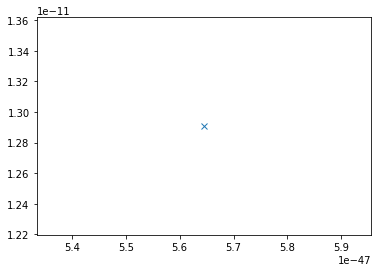

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



4.424994282792004e-61 5 (8, 7, 15)
1 step, max temperature:  300.00019020054094
2.4865108162880264e-68 5 (6, 8, 14)
2 step, max temperature:  300.0002637446457
1.8978345762861215e-94 5 (6, 8, 15)
3 step, max temperature:  300.0003145339678
9.348062042374052e-96 5 (7, 8, 14)
4 step, max temperature:  300.00035626319857
4.0906320712520625e-101 5 (6, 8, 16)
5 step, max temperature:  300.00038389519125
1.5800426342429199e-145 5 (7, 8, 15)
6 step, max temperature:  300.000411111996
6.078127521416502e-129 5 (7, 7, 14)
7 step, max temperature:  300.0004337990324
9.5309037262858e-117 5 (8, 8, 14)
8 step, max temperature:  300.0004509364409
1.9271890544860364e-108 5 (8, 7, 16)
9 step, max temperature:  300.00046631411
8.385572756418107e-125 5 (8, 6, 14)
10 step, max temperature:  300.00047604998406
5.645127504287624e-47


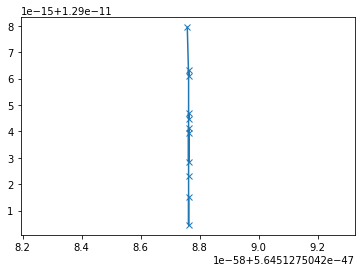

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



7.897126738783043e-158 5 (8, 6, 15)
11 step, max temperature:  300.0004881404971
3.157135143990298e-143 5 (7, 6, 14)
12 step, max temperature:  300.00049469506666
8.994086975397877e-126 5 (7, 7, 15)
13 step, max temperature:  300.0005009804282
1.5075745653133817e-164 5 (6, 7, 14)
14 step, max temperature:  300.00050185425863
8.326545264450209e-115 5 (6, 7, 15)
15 step, max temperature:  300.00050279464347
6.605928062686144e-123 5 (6, 6, 14)
16 step, max temperature:  300.00050141425925
1.1516579938230182e-103 5 (8, 8, 15)
17 step, max temperature:  300.00049870146495
1.4612965833585503e-89 6 (8, 9, 13)
18 step, max temperature:  300.00049381542135
4.2544038133891616e-161 5 (8, 9, 14)
19 step, max temperature:  300.0004906791166
5.3227715637510486e-176 6 (8, 9, 12)
20 step, max temperature:  300.00048726245075
5.645127504287624e-47


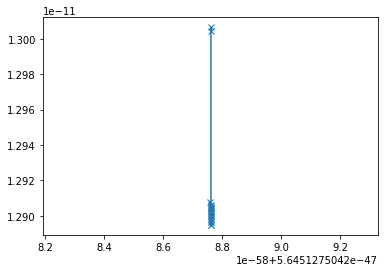

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



3.809570377316263e-106 6 (8, 10, 12)
21 step, max temperature:  300.00048533048647
3.208113782308759e-152 5 (8, 10, 13)
22 step, max temperature:  300.00048411716676
1.272269788830276e-92 5 (8, 10, 14)
23 step, max temperature:  300.0004827995641
2.0918595428848894e-105 5 (8, 10, 15)
24 step, max temperature:  300.00048130301553
3.8346822129919905e-96 5 (8, 10, 16)
25 step, max temperature:  300.00047917830966
4.705302366670978e-97 5 (8, 9, 15)
26 step, max temperature:  300.0004787448051
1.3972674768443286e-117 6 (7, 9, 13)
27 step, max temperature:  300.0004777161413
8.450408036861344e-181 5 (7, 9, 14)
28 step, max temperature:  300.0004781459429
1.3536623700147597e-195 6 (7, 9, 12)
29 step, max temperature:  300.00047776338494
2.8332054337764103e-106 6 (7, 10, 12)
30 step, max temperature:  300.0004785610772
5.645127504287624e-47


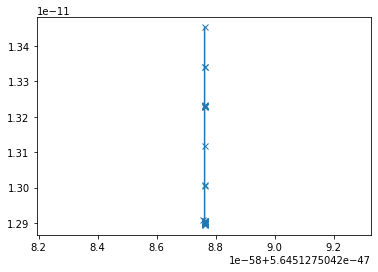

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



3.006121953634658e-171 5 (7, 10, 13)
31 step, max temperature:  300.00047880369465
6.873478830386604e-104 5 (7, 10, 14)
32 step, max temperature:  300.00048004290846
2.392234136711857e-117 5 (7, 10, 15)
33 step, max temperature:  300.0004802869948
5.837686862426805e-100 6 (9, 8, 13)
34 step, max temperature:  300.00048124197775
1.5114585133899266e-158 5 (9, 8, 14)
35 step, max temperature:  300.00048184465606
1.5249587009141906e-196 6 (9, 8, 12)
36 step, max temperature:  300.00048297627717
2.5047905983612017e-102 6 (10, 8, 12)
37 step, max temperature:  300.00048384972587
3.238821432231052e-152 5 (10, 8, 13)
38 step, max temperature:  300.00048514908974
1.181096274498872e-99 5 (10, 8, 14)
39 step, max temperature:  300.00048629898777
6.2423433628170065e-105 5 (10, 8, 15)
40 step, max temperature:  300.0004876232166
5.645127504287624e-47


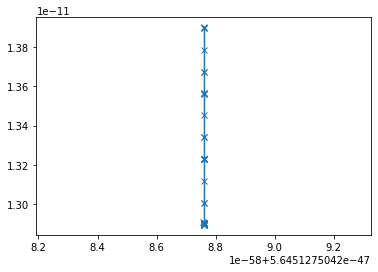

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



8.839217308591074e-102 5 (10, 8, 16)
41 step, max temperature:  300.00048892645054
5.250739171813359e-102 5 (9, 8, 15)
42 step, max temperature:  300.00049042929953
5.871110902976534e-114 6 (9, 9, 13)
43 step, max temperature:  300.00049199383267
6.489652967551931e-186 5 (9, 9, 14)
44 step, max temperature:  300.000493404477
2.325533637272892e-195 6 (9, 9, 12)
45 step, max temperature:  300.00049512915535
4.753839090702951e-111 6 (9, 7, 13)
46 step, max temperature:  300.00049638866096
6.420213717365377e-177 5 (9, 7, 14)
47 step, max temperature:  300.00049830445425
1.8476943902257785e-176 6 (9, 7, 12)
48 step, max temperature:  300.0004994804127
1.0407366379401792e-104 6 (10, 7, 12)
49 step, max temperature:  300.0005014329073
5.019949060450886e-159 5 (10, 7, 13)
50 step, max temperature:  300.00050268237226
5.645127504287624e-47


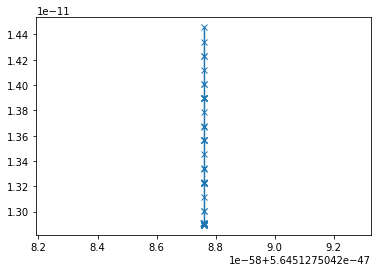

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



2.6749369511136972e-114 5 (10, 7, 14)
51 step, max temperature:  300.0005050435258
1.725274348784031e-143 5 (10, 7, 15)
52 step, max temperature:  300.000506876498
2.6079486649754654e-96 6 (6, 9, 13)
53 step, max temperature:  300.00050940724765
6.110979762494634e-101 5 (6, 9, 14)
54 step, max temperature:  300.00051129233384
9.268470740575186e-161 6 (6, 9, 12)
55 step, max temperature:  300.0005137364802
3.53147586362282e-113 5 (6, 9, 15)
56 step, max temperature:  300.00051569214537
6.126095847788625e-95 6 (9, 10, 12)
57 step, max temperature:  300.0005179764483
1.0818937368821555e-158 5 (9, 10, 13)
58 step, max temperature:  300.0005199732768
5.379730750725037e-106 5 (9, 10, 14)
59 step, max temperature:  300.00052232697504
8.055380891530185e-119 5 (9, 10, 15)
60 step, max temperature:  300.0005245440963
5.645127504287624e-47


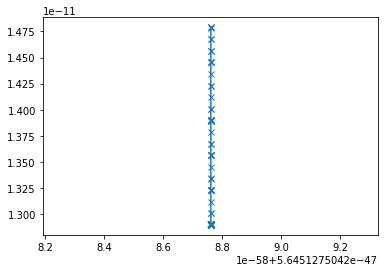

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



1.943115860407088e-97 6 (10, 9, 12)
61 step, max temperature:  300.0005269394965
1.0033806909077882e-168 5 (10, 9, 13)
62 step, max temperature:  300.00052907904495
3.712699306483025e-101 5 (10, 9, 14)
63 step, max temperature:  300.0005313454932
1.2396428910238777e-112 5 (10, 9, 15)
64 step, max temperature:  300.00053352562617
8.278998602190888e-94 6 (6, 10, 13)
65 step, max temperature:  300.0005355765793
2.548919715952548e-157 5 (6, 10, 14)
66 step, max temperature:  300.0005377990013
4.3435345581529364e-191 6 (6, 10, 12)
67 step, max temperature:  300.0005396102277
4.686763516207347e-113 6 (6, 11, 12)
68 step, max temperature:  300.0005419667618
3.4694265145036415e-163 5 (6, 11, 13)
69 step, max temperature:  300.0005435378866
6.511676515114581e-93 5 (6, 11, 14)
70 step, max temperature:  300.0005461379569
5.645127504287624e-47


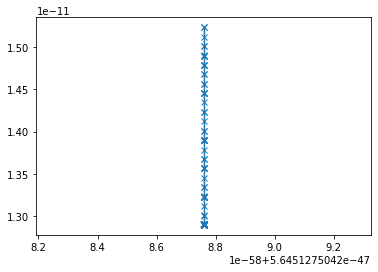

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



5.5952141518980836e-93 5 (6, 11, 15)
71 step, max temperature:  300.00054761162835
1.713592570500183e-91 6 (6, 5, 12)
72 step, max temperature:  300.00055049469734
7.822847340668731e-157 5 (6, 5, 13)
73 step, max temperature:  300.0005517355254
4.7047082964267535e-91 6 (9, 6, 13)
74 step, max temperature:  300.0005547314092
5.749628955549593e-104 5 (9, 6, 14)
75 step, max temperature:  300.00055583279345
1.065657598040293e-160 6 (9, 6, 12)
76 step, max temperature:  300.00055897437915
6.076630592895441e-103 6 (10, 6, 12)
77 step, max temperature:  300.0005604203766
1.3083778243745063e-159 5 (10, 6, 13)
78 step, max temperature:  300.00056314462046
3.4855980244495875e-104 5 (10, 6, 14)
79 step, max temperature:  300.000564862711
4.225611893500177e-94 5 (9, 7, 15)
80 step, max temperature:  300.0005678439317
5.645127504287624e-47


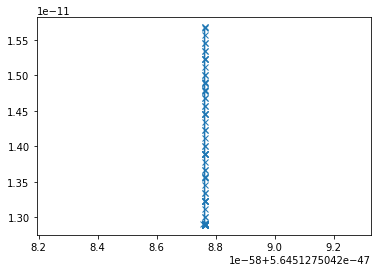

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



9.981847934179149e-90 6 (5, 10, 12)
81 step, max temperature:  300.00056985573104
1.2067599928608236e-158 5 (5, 10, 13)
82 step, max temperature:  300.000572853751
2.3743606649484076e-91 6 (9, 5, 12)
83 step, max temperature:  300.00057485264745
1.0712729382230458e-161 5 (9, 5, 13)
84 step, max temperature:  300.00057764582874
7.184054475065023e-92 5 (6, 11, 16)
85 step, max temperature:  300.0005796788528
7.235208381481453e-98 5 (6, 10, 15)
86 step, max temperature:  300.0005821552534
7.444717762401869e-189 5 (5, 10, 14)
87 step, max temperature:  300.00058420233114
4.1361490532962445e-108 6 (5, 9, 13)
88 step, max temperature:  300.0005864086864
1.7902254103873272e-97 5 (5, 9, 14)
89 step, max temperature:  300.00058856864723
7.448499105169126e-191 6 (5, 9, 12)
90 step, max temperature:  300.00059048464703
5.645127504287624e-47


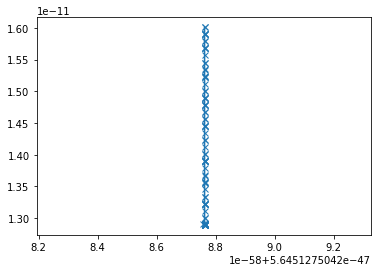

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:742: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:753: RuntimeWarning:

invalid value encountered in multiply

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:671: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:890: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1615: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1620: RuntimeWarning:

divide by zero encountered in true_divide

/Users/fedor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1625: RuntimeWarning:

divide by zero encountered in true_divide



5.695730934167726e-110 6 (4, 9, 12)
91 step, max temperature:  300.00059282312395
1.3575405109799044e-182 5 (4, 9, 13)
92 step, max temperature:  300.0005945815337
5.115276163090506e-97 6 (5, 8, 13)
93 step, max temperature:  300.000597105577
5.604021135297402e-94 5 (5, 8, 14)
94 step, max temperature:  300.00059882033116
3.6713581987894196e-145 6 (5, 8, 12)
95 step, max temperature:  300.0006015398862
2.7775853007872638e-123 5 (5, 8, 15)
96 step, max temperature:  300.00060333299723
2.6211064544754984e-101 6 (5, 7, 13)
97 step, max temperature:  300.000606117112
1.4606971381470248e-166 5 (5, 7, 14)
98 step, max temperature:  300.00060789663144
1.1672271053055628e-165 6 (5, 7, 12)
99 step, max temperature:  300.00061081713085
2.0165200628514354e-90 6 (4, 7, 12)
100 step, max temperature:  300.00061283009535
5.645127504287624e-47


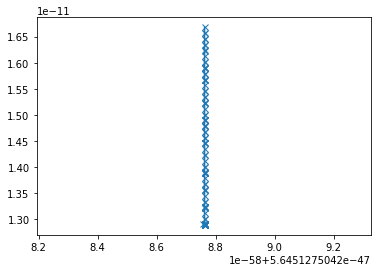

In [8]:
for i in range(101):
    struct.complete_model_step()
    # if i > 0:
    #     struct.update_trap_ocupancy()

    current.append(struct.current)
    max_temperature.append(np.max(struct.temperature))
    time_step.append(struct.simulation_time)
    max_field.append(np.max(struct.electric_potential_grad))
    print(f'{i} step, max temperature: ', np.max(struct.temperature))

    if np.isnan(struct.time_step):
        break

    if i%10 == 0:
        print(struct.simulation_time)


        plt.plot(time_step, elementary_charge*np.array(current), '-x')
        plt.show()


        df, df_p = parse_array_for_plot(struct.vacancy_grid, struct.vacancy_clusters, struct.percolation_cluster_cnt)

        # TODO: set initial plot scale
        # Marker size depend on plot scale
        marker_size = struct.vacancy_radius*10#86.5 
        fig = px.scatter_3d(df_p, x='x', y='y', z='z', opacity=0.3)
        fig.update_traces(marker=dict(size=marker_size, symbol="circle"),
                        selector=dict(mode='markers'))
        fig.show()

        # plot_cube(struct.electric_potential_grad[5:15, 5:8, :])
        # plot_cube(struct.electric_potential[5:15, 5:8, :])
        # plot_cube(struct.temperature)


### Описание реализации кинетического Монте-Карло для движения вакансий
- Используется метод первой реакции (англ.: first reaction method or descrite event system simulation)

#### Алгоритм вычисления частот реакций
- __Пусть:__
    - _V_ - бинарная матрица с расположением вакансий (1 - вакансия есть, 0 - вакансия отсутствует)
    - _T_ - матрица с распределением температуры
    - $\Phi$ - матрица с распределением электрического потенциала
    - $C_i$ - набор матриц с операторами свертки:
        0. Ядро переноса вакансии вверх (вдоль оси z)
            $$\begin{bmatrix} 0 & 1 & 0 \\ 0 & -1 & 1 \\ 0 & 2 & 4 \end{bmatrix}$$

#### Алгоритм модели
1. Задание начальной конфигурации модели
    - Генерация решетки
    - Задание начального распределения вакансий на решетке
    - Генерация матрицы возникновения процесса для каждой ячейки решетки

2. 



In [ ]:


#https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.convolve.html

In [ ]:
""" 
(x,y,z) : tuple
    3D index of the point

ambient_temperature : const
    Value of the ambient temperature

center_element_coord : tuple
    3D array of coordinate (x,y,z)

coord_1d : np.array
    1D index of the point

coord_3d : list
    3D index of the point

coordinate_z : np.array
    3D array with the same value on XOY planes, that equal to OZ index

current : constant
    Current flowing thorugh the dielectric

defect_permittivity : const
    Permitivity value of the defect,
    just very large value

distances : np.array
    3D array that contains the value of  distance in every cell from given one (center_element_coord).
    Distance at (center_element_coord) is equal to zero

E : const
    Electron energy    

electric_potential : np.array
    3D array with value of electric potential in every matrix cell

electron_effective_mass : const
    Effective mass of electron (from scipy.constants)

elementary_charge : const
    Elementary charge (from scipy.constants)

eV_to_J : const
    Conversion factor from electron-volts to Joule

flatten_index : int
    1D index of the point

hbar : const
    Plank's constatnt (from scipy.constants)

insulator_permittivity_array : np.array
    3D array that contains the value of permittivity in every cell

lattice_constant : const
    The side size of a square cell of the calculation grid

mask : np.array
    Binary 3D mask, to simplify calculation by
    only choosing cell with vacancies

neighbor_kernel : np.array
    3D array, convolution kernel that determines whether there are
    defects around the neighboring cells or not

nx : const
    Grid size along OX
ny : const
    Grid size along OY
nz : const
    Grid size along OZ

nm_to_cm : const
    Conversion factor from nanometers to centimeters
    
oxide_permittivity : const
    Permitivity value of the oxide

power_dissipation_map : np.array
    3D array with value of power dissipation (due to the interaction of the lattice with phonons) in every matrix cell

temperature : np.array
    3D array with value of temperature in every matrix cell

thermal_conductivity : np.array
    3D array with value of thermal_conductivity in every matrix cell

trap_capture_rate : np.array
    Rate of electron entry event to trap

trap_emission_rate : np.array
    Rate of electron escape event from trap

trap_occupancy : np.array
    Probability that there is an electron in this trap

trap_level : np.array
    3D array of trap depths relative to the bottom of the conduction band

tunn_probability : np.array
    3D array with values of tunneling probabilities out of the trap (with coordinate 'vacancy_coord') to the other traps.
    Consider only the cubic sliced dependend on the OZ grid size (nz).

V_bottom : const
    Voltage at the bottom electrode
V_bottom : const
    Voltage at the top electrode

V_ox : const
    Total voltage drop

vacancy_coord : tuple
    3D array of coordinate (x,y,z)

vacancy_grid : np.array
    Defect positions            
"""

' \n(x,y,z) : tuple\n    3D index of the point\n\ncoord_1d : np.array\n    1D index of the point\n\ncoord_3d : list\n    3D index of the point\n\ndefect_permittivity : const\n    Permitivity value of the defect,\n    just very large value\n\nflatten_index : int\n    1D index of the point\n\noxide_permittivity : const\n    Permitivity value of the oxide\n\n\n\n\n\ninsulator_permittivity_array : np.array\n    3D array that contains the value of permittivity in every cell\n\nelectric_potential : np.array\n    3D array with value of electric potential in every matrix cell.\n               \n'